Este código permite simmular el movimiento de un cuerpo de masa despreciable si está influenciado por Júpiter y el Sol.

En casillas importantes explicaremos con texto lo que se realizó, en otro caso los comentarios son suficientes para entender.

In [276]:
#Librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.integrate import odeint

#Para crear un video de la trayectoria coon moviepy
#La documentación se encuentra en https://zulko.github.io/moviepy/getting_started/videoclips.html
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import matplotlib.pyplot as plt
import gizeh
from matplotlib.pyplot import figure

In [277]:
#Datos relevantes del Sistema de Júpiter y el Sol
#Estos se obtuvieron de http://www.sc.ehu.es/sbweb/fisica3/celeste/jupiter/jupiter.html

#Sol
m1 = 1.989e30 #Masa en kg

#Júpiter
m2 = 1.898e27 #Masa en Kg
L = 7.7835e8 #Semieje mayor en km
e = 0.048 #Excentricidad

#Constante Gravitacional
G = 6.673e-11 


El parámetro de masa recordemos que se define como
$$\mu=\frac{m_2}{m_1+m_2}.$$

Lo calcularemos para nuestros planetas pero con las unidades normalizadas, es decir, para nuevas $m_1$ y $m_2$ obtenidas de las originales tales que 
$$G(m_1+m_2) = 1$$

In [278]:
#Reparametrización
M = 1/(G*(m1+m2))
m1 = m1/M
m2 = m2/M

#Cálculo del parámetro de masa 
mu = m2/(m1+m2)

Calcularemos ahora la trayectoria de Júpiter y el Sol. Recordemos que asumimos que el Sol se encuentra en el origen en todo momento y la posición de Júpiter está dictada por la fórmula
$$r(\theta) = \frac{1-ɛ^2}{1+ɛ\cos(\theta)},$$
pues ya hizimos la reparametrización de las unidades. Recordemos que entonces todas nuestras velocidades deben ser cambios respecto a $\theta$ y no el tiempo.

In [279]:
### Obtenemos los radios y la posicion de los cuerpos principales

#La cantidad de pasos
n = 10000

#El total de la trayectoria que Júpiter relizará.
#Utilice este para obtener una fracción o múltiplo de la trayectoria de Júpiter
#Recuerde que 2pi implica una trayectoria completa
trayectoria = 2*np.pi

#El cambio de theta
theta = trayectoria/n

#Vector para guardar las distancias del Sol a Júpiter
r = np.zeros(n)

#Vector para guardar la posición del Sol
coorP1 = np.zeros((n,2))

#Vector para guardar la posición de Júpiter
coorP2 = np.zeros((n,2))

#Cálculo de las posiciones de ambos cuerpos celestes
for i in range(0,n):
  r[i] = (1-e**2)/(1+e*np.cos(i*theta))
  coorP1[i][0] = 0
  coorP1[i][1] = 0

  coorP2[i][0] = r[i]*np.cos(theta*i)
  coorP2[i][1] = r[i]*np.sin(theta*i)

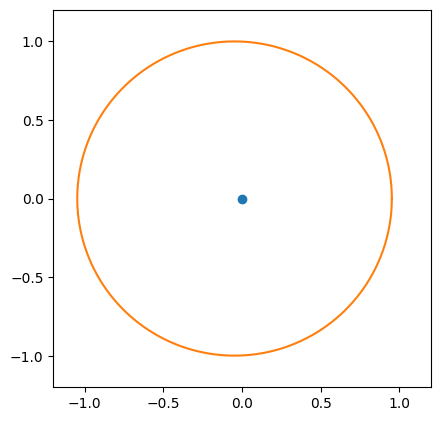

In [280]:
#Código para imprimir la trayectorias obtenidas

figure(figsize=(5,5), dpi = 100)
plt.plot(coorP1[:,0], coorP1[:,1])
plt.plot(coorP2[:,0], coorP2[:,1])

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(0,0)

plt.show()

A continuación definimos las funciones necesarias para que ODEint pueda solucionar nuestro sistema. Este resolverá un sistema de la forma
$$S(x,y,v_x,v_y).$$

Usando la fórmula obtenida en las notas, ocurre que el cambio de $v_x$ respecto a $\theta$ se puede calcular como sigue:
$$\frac{dv_x}{d\theta} = \frac{r^4}{1-ɛ^2}\left(\frac{\mu-1}{\|(x,y)\|^3} + \frac{\mu}{\|(x,y)-(x_2,y_2)\|}(x_2-x)+\frac{2(1-ɛ^2)^2ɛ\sin(\theta)}{r^5(1+ɛ\cos(\theta))^2}v_x\right),$$

donde $x_2 = r\cos(\theta)$ y $y_2 = r\sin(\theta)$. De manera análoga obtenemos 

$$\frac{dv_y}{d\theta} = \frac{r^4}{1-ɛ^2}\left(\frac{\mu-1}{\|(x,y)\|^3} + \frac{\mu}{\|(x,y)-(y_2,y)\|}(x_2-x)+\frac{2(1-ɛ^2)^2ɛ\sin(\theta)}{r^5(1+ɛ\cos(\theta))^2}v_y\right).$$

In [281]:
#Esta función es la que pasaremos a odeint

def dSdf(S,theta):
  x, y, vx, vy = S

  #La distancia entre los dos planetas mayores
  r = (1-e**2)/(1+e*np.cos(theta))


  #La posicion de los planetas
  x1 = 0
  y1 = 0
  x2 = r*np.cos(theta)
  y2 = r*np.sin(theta)

  #La distancia al tercer objeto
  r1 = np.sqrt(x**2 + y**2)
  r2 = np.sqrt((x-x2)**2 + (y-y2)**2)

  #Para facilidad de escritura
  r1 = r1**3
  r2 = r2**3
  h = np.sqrt(1-e**2)

  #Calculamos la aceleracion
  ax = (mu-1)*x/r1 + mu*(x2-x)/r2 + 2*((1-e**2)**2)*e*np.sin(theta)*vx/((1+e*np.cos(theta))**2)
  ay = (mu-1)*y/r1 + mu*(x2-y)/r2 + 2*((1-e**2)**2)*e*np.sin(theta)*vx/((r**5)*(1+e*np.cos(theta))**2)

  ax = (r**4)*ax/(1 - e**2)
  ay = (r**4)*ay/(1 - e**2)

  return [
         vx,
         vy,
         ax,
         ay
  ]
  

In [282]:
#Los cambios en theta que usaremos para calcular el movimiento del tercer cuerpo
#Este vector se lo pasamos a ODEint

#Una n mayor dará resultados más precisos 
n = 10000



#Usamos la variable trayectoria pues ese indica el total de vueltas al rededor
#del Sol que Júpiter realiza y nos interesa saber como se mueve el tercer cuerpo
#en ese mismo periodo
angles = np.linspace(0,trayectoria, n)

Aquí se pone una casilla para los datos iniciales del tercer cuerpo. Modifque estos datos para obtener diferentes resultados. Aquí, "x0" es la posición inicial en el eje horizontal, "y_0", en el vertical y "vx0" y "vy0" las velocidades iniciales en sus ejes respectivos.

Recuerde que las unidades están reparamentrizadas por lo que $x_0=1$ y $y_0=0$ pondrían al tercer cuerpo en la misma posición que Júpiter. 

In [283]:
x0 = 0.5
y0 = 0
vx0 = 0
vy0 = 1

In [284]:
#Generamos el vector con las posiciones del tercer cuerpo
sol = odeint(dSdf, y0 = [x0, y0, vx0, vy0], t=angles)

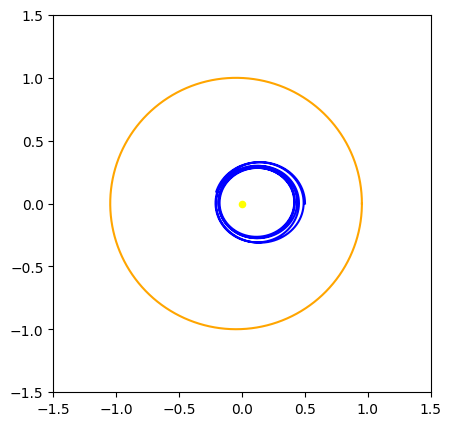

In [285]:
#Graficamos las trayectorias de los tres cuerpos después del total
#de una vuelta alrededor del Sol determinada por "trayectoria"

m = 10000
tercerX = np.zeros(m)
tercerY = np.zeros(m)
coorP2X = np.zeros(m)
coorP2Y = np.zeros(m)

for i in range(m):
  tercerX[i] = sol[i][0]
  tercerY[i] = sol[i][1]
  coorP2X[i] = coorP2[:,0][i]
  coorP2Y[i] = coorP2[:,1][i]


#Dibujamos la elipse
figure(figsize=(5,5), dpi = 100)
plt.plot(coorP1[:,0], coorP1[:,1])
plt.plot(coorP2X, coorP2Y, c = "orange")
plt.plot(tercerX, tercerY, c = "blue")
plt.scatter(0,0, c = "yellow", s = 20)

#Valores recomendados
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

[MoviePy] >>>> Building video my_video_file.mp4
[MoviePy] Writing video my_video_file.mp4


100%|█████████▉| 446/447 [00:49<00:00,  9.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_video_file.mp4 



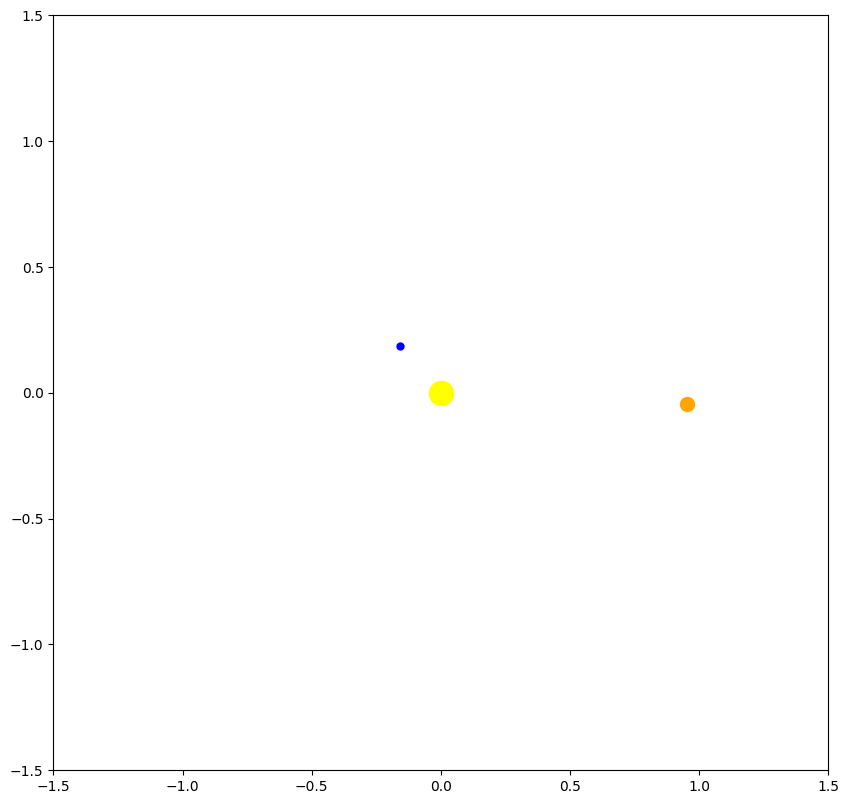

In [286]:
#Hacemos un video de la trayectoria
x1 = np.zeros(m)
x2 = coorP2X
x3 = tercerX

y1 = np.zeros(m)
y2 = coorP2Y
y3 = tercerY

x = np.linspace(-2, 2, 200)

duration = 22.3

fig, ax = plt.subplots()
#Cantidad recomendada, modificar según sea la necesidad
fig.set_size_inches(10,10)
fig.set_dpi(100)

def make_frame(t):
    ax.clear()
    ax.scatter(x3[int(t*duration*20)], y3[int(t*duration*20)], c = "blue", s = 25)
    ax.scatter(x2[int(t*duration*20)], y2[int(t*duration*20)], c = "orange",s = 100)
    ax.scatter(x1[int(t*duration*20)], y1[int(t*duration*20)], c = "yellow", s = 300)
    #Estos son valores sugeridos. Cambiar dependiendo las trayectorias obtenidas
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(-1.5,1.5)
    return mplfig_to_npimage(fig)


clip = VideoClip(make_frame, duration=duration) # for custom animations (see below)
clip.write_videofile("my_video_file.mp4", fps = 20)

#Si se quiere como Gif

#animation = VideoClip(make_frame, duration=duration)
#animation.write_gif('matplotlib.gif', fps=20)
